# Single-Sideband Modulation Demo

This notebook is a template for producing single-sideband modulated pulses using the RFSoC 4x2.

In [1]:
# Import libraries
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../rfsoc_lib')
from rfsoc_calibration import RfsocCalibration
from rfsoc_pulses import RfsocPulses

import pickle
import rpyc
import time
from IPython.display import clear_output
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Board libraries
from qick import *
import Pyro4

# Pyro communicates with board
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "172.24.106.21" # <-- SET IP ADDRESS
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)


QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by o

In [3]:
# Multimeter configuration
config = {"allow_public_attrs": True,
          "allow_all_attrs": True,
          "allow_setattr":True,
          "allow_delattr": True,
          "allow_pickle":True,
          "sync_request_timeout": 10,
          }

exp_local = rpyc.connect("172.24.106.22", port=12346, config=config).root

In [20]:
max_voltage_freq = {}

min_freq = 2500
max_freq = 4000
freq_step = 10 # [MHz]
freqs_Mhz = np.arange(min_freq, max_freq+freq_step, freq_step)

DAQ = exp_local.get_device('RemoteNIDAQ')
DAQ_ch = 1

amp = 32565
for freq_Mhz in freqs_Mhz:
    # Program DAC registers
    soc.reset_gens()
    prog = QickProgram(soccfg)
    for ch in range(2): # Both DACs
        prog.declare_gen(ch=ch, nqz=1) # Initialise DAC
        prog.set_pulse_registers(ch = ch,
                                    gain = int(amp),
                                    freq = prog.freq2reg(freq_Mhz, gen_ch=ch),
                                    phase = prog.deg2reg(0, gen_ch=ch),
                                    style = "const",
                                    length = prog.us2cycles(100, gen_ch=ch),
                                    mode = "periodic", # Constant output
                                    )
        prog.pulse(ch=ch, t=0) # Trigger DAC
    prog.config_all(soc) # Configure for internal start
    soc.tproc.start() # Internal start
    # print(prog)

    time.sleep(0.1)
    voltage = DAQ.measure_voltage(DAQ_ch, 10)
    clear_output(wait=True)
    print(f"Freq: {freq_Mhz} MHz, Volt: {round(voltage, 3)} V")

    max_voltage_freq[freq_Mhz] = voltage

Freq: 4000 MHz, Volt: 0.163 V


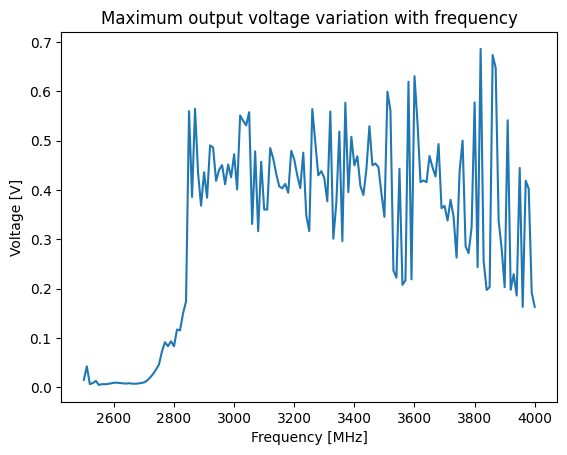

In [21]:
# Plot calibrated parameters
freqs, voltages = [], []
for freq, voltage in max_voltage_freq.items():
    freqs.append(freq)
    voltages.append(voltage)

plt.plot(freqs, voltages)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Voltage [V]")
plt.title("Maximum output voltage variation with frequency");
plt.show()

In [51]:
const_power_gains = {}

target_voltage = 1.4
prop = 3000

min_freq = 2875
max_freq = 3200
freq_step = 1 # [MHz]
freqs_Mhz = np.arange(min_freq, max_freq+freq_step, freq_step)

DAQ = exp_local.get_device('RemoteNIDAQ')
DAQ_ch = 1

amp = 5000
for freq_Mhz in freqs_Mhz:
    clear_output(wait=True)
    print(f"\nFreq: {freq_Mhz} MHz - {round(list(freqs_Mhz).index(freq_Mhz)*100/len(freqs_Mhz),1)}%")
    iters = 0
    calibrated = False

    while calibrated == False:
        iters += 1

        # Program DAC registers
        soc.reset_gens()
        prog = QickProgram(soccfg)
        for ch in range(2): # Both DACs
            prog.declare_gen(ch=ch, nqz=1) # Initialise DAC
            prog.set_pulse_registers(ch = ch,
                                     gain = int(amp),
                                     freq = prog.freq2reg(freq_Mhz, gen_ch=ch),
                                     phase = prog.deg2reg(0, gen_ch=ch),
                                     style = "const",
                                     length = prog.us2cycles(100, gen_ch=ch),
                                     mode = "periodic", # Constant output
                                     )
            prog.pulse(ch=ch, t=0) # Trigger DAC
        prog.config_all(soc) # Configure for internal start
        soc.tproc.start() # Internal start
        # print(prog)

        time.sleep(0.1)
        voltage = DAQ.measure_voltage(DAQ_ch, 10)
        print(f"[{iters}] Volt: {round(voltage, 3)}, Amp.: {round(amp, 0)}")

        if abs(voltage - target_voltage) < 0.002:
            const_power_gains[freq_Mhz] = amp
            calibrated = True
        else:
            error = target_voltage - voltage
            amp += prop * error

            if iters > 20 and amp > 32766:
                const_power_gains[freq_Mhz] = 32766
                calibrated = True


Freq: 3200 MHz - 99.7%
[1] Volt: 1.407, Amp.: 11645.0
[2] Volt: 1.401, Amp.: 11623.0


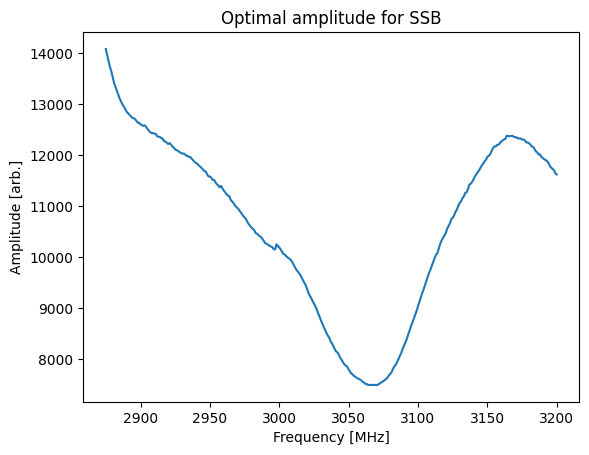

In [52]:
# Plot calibrated parameters
freqs, amps = [], []
for freq, amp in const_power_gains.items():
    freqs.append(freq)
    amps.append(amp)

plt.plot(freqs, amps)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Amplitude [arb.]")
plt.title("Optimal amplitude for SSB");
plt.show()

In [54]:
# SSB parameters
freq_Mhz = 3115

# Program DAC registers
prog = QickProgram(soccfg)
soc.reset_gens()
for ch in range(2): # Both DACs
    prog.declare_gen(ch=ch, nqz=1) # Initialise DAC
    prog.set_pulse_registers(ch = ch,
                             gain = int(const_power_gains[freq_Mhz]),
                             freq = prog.freq2reg(freq_Mhz, gen_ch=ch),
                             phase = prog.deg2reg(0, gen_ch=ch),
                             style = "const",
                             length = prog.us2cycles(100, gen_ch=ch),
                             mode = "periodic", # Constant output
                            )
    prog.pulse(ch=ch, t=0) # Trigger DAC

# Start DACs
prog.config_all(soc) # Configure for internal start
soc.tproc.start() # Internal start
print(prog)


// Program

  regwi 0, $22, 340241066;                      //freq = 1360964267
  bitwi 0, $22, $22 << 2;
  mathi 0, $22, $22 + 3;
  regwi 0, $23, 0;                              //phase = 0
  regwi 0, $25, 10168;                          //gain = 10168
  regwi 0, $26, 913408;                         //phrst| stdysel | mode | | outsel = 0b01101 | length = 61440 
  regwi 0, $27, 0;                              //t = 0
  set 0, 0, $22, $23, $0, $25, $26, $27;        //ch = 0, pulse @t = $27
  regwi 1, $22, 340241066;                      //freq = 1360964267
  bitwi 1, $22, $22 << 2;
  mathi 1, $22, $22 + 3;
  regwi 1, $23, 0;                              //phase = 0
  regwi 1, $25, 10168;                          //gain = 10168
  regwi 1, $26, 913408;                         //phrst| stdysel | mode | | outsel = 0b01101 | length = 61440 
  regwi 1, $27, 0;                              //t = 0
  set 1, 1, $22, $23, $0, $25, $26, $27;        //ch = 1, pulse @t = $27


In [263]:
voltage = DAQ.measure_voltage(DAQ_ch, 10)
print(round(voltage,3))

1.243


In [56]:
# to save the data
with open('../pickles/const_power.pickle', 'wb') as handle:
    pickle.dump(const_power_gains, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [55]:
# Stop DACs
soc.reset_gens()